In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Using `mutate` for pre-processing and feature engineering  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/mutate/abstract_functionality_blueprint/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/mutate/abstract_functionality_blueprint/notebook.ipynb)


We give some application suggestions for mutating the outputs of functions in a distributed manner with `@mutate.`
When you scroll through the notebook we build examples from most straight forward applications to more complex logic that showcases the amount of flexibility you get with this decorator.

Mutate gives the ability to apply the same transformation to the each output of multiple functions in the DAG. It can be particularly useful in the following scenarios:

1. Loading data and applying pre-cleaning step.
2. Feature engineering via joining, filtering, sorting, applying adjustment factors on a per column basis etc.
3. Experimenting with different transformations across nodes by selectively turning transformations on / off.


and effectively replaces:
1. Having to have unique names and then changing wiring if you want to add/remove/replace something.
2. Enabling more verb like names on functions.
3. Potentially simpler "reuse" of transform functions across DAG paths...

In [1]:
# from hamilton import registry
# registry.disable_autoload()

%load_ext hamilton.plugins.jupyter_magic
from hamilton import driver

/Users/jernejfrank/miniconda3/envs/hamilton/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/Users/jernejfrank/miniconda3/envs/hamilton/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final data 1
  col_1 col_2
3     0     d
1     2     b
0     3     a
Final data 2
      col_1  col_2
col_2             
150       a     10
155       b     23
145       c     32
200       d     50
5000      e      0


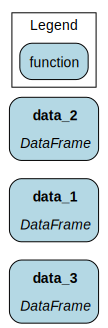

In [2]:
%%cell_to_module -m procedural --display

from typing import Any, List
import pandas as pd


def data_1()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [3, 2, pd.NA, 0], 'col_2': ['a', 'b', pd.NA, 'd']})
    return df

def data_2()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': ['a', 'b', pd.NA, 'd', 'e'], 'col_2': [150, 155, 145, 200, 5000]})
    return df

def data_3()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [150, 155, 145, 200, 5000], 'col_2': [10,23, 32, 50, 0]})
    return df

# data1 and data2
def _filter(some_data:pd.DataFrame)->pd.DataFrame:
    return some_data.dropna()

# data 2
# this is for value
def _add_missing_value(some_data:pd.DataFrame, missing_row:List[Any])->pd.DataFrame:
    some_data.loc[-1] = missing_row
    return some_data

# data 2
# this is for source
def _join(some_data:pd.DataFrame, other_data:pd.DataFrame)->pd.DataFrame:
    return some_data.set_index('col_2').join(other_data.set_index('col_1'))

# data1 and data2
def _sort(some_data:pd.DataFrame)->pd.DataFrame:
    columns = some_data.columns
    return some_data.sort_values(by=columns[0])

if __name__ == "__main__":
    # print("Filter data 1")
    # print(_filter(data_1()))
    # print("Sort data 1")
    print("Final data 1")
    print(_sort(_filter(data_1())))
    # print("Filter data 2")
    # print(_filter(data_2()))
    # print("Add missing value data 2")
    # print(_add_missing_value(_filter(data_2()),missing_row=['c', 145]))
    # print("Join data 2 and data 3")
    # print(_join(_add_missing_value(_filter(data_2()),missing_row=['c', 145]),other_data=data_3()))
    # print("Sort joined dataframe")
    print("Final data 2")
    print(_sort(_join(_add_missing_value(_filter(data_2()),missing_row=['c', 145]),other_data=data_3())))

In [3]:
node_to_execute = ["data_1", "data_2", "feat_A"]

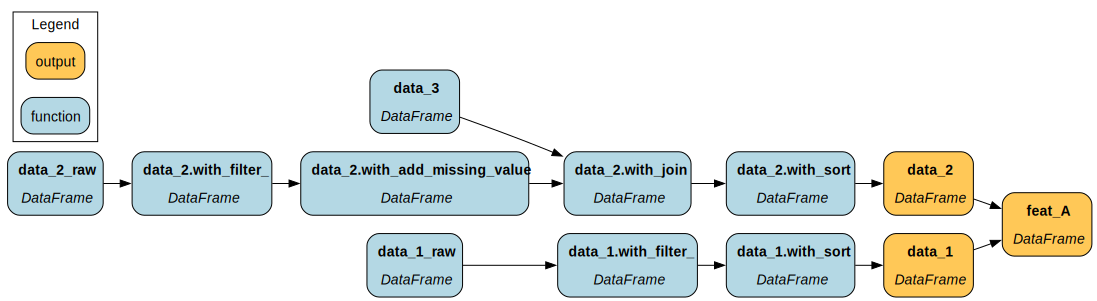

,col_1,col_2
3,0,d
1,2,b
0,3,a


,col_1,col_2
col_2,,
150,a,10
155,b,23
145,c,32
200,d,50
5000,e,0


,col_0,col_1,col_3,col_2
0,d,0,200,50
1,b,2,155,23
2,a,3,150,10


In [4]:
%%cell_to_module -m pipe_output --display --write_to_file --execute node_to_execute

from typing import Any, List
import pandas as pd
from hamilton.function_modifiers import pipe_output, step, source, value, hamilton_exclude

# data1 and data2
@hamilton_exclude
def filter_(some_data:pd.DataFrame)->pd.DataFrame:
    return some_data.dropna()

@hamilton_exclude
def test_foo(a,b,c):
    return a+b+c

# data 2
# this is for value
@hamilton_exclude
def add_missing_value(some_data:pd.DataFrame, missing_row:List[Any])->pd.DataFrame:
    some_data.loc[-1] = missing_row
    return some_data

# data 2
# this is for source
@hamilton_exclude
def join(some_data:pd.DataFrame, other_data:pd.DataFrame)->pd.DataFrame:
    return some_data.set_index('col_2').join(other_data.set_index('col_1'))

# data1 and data2
@hamilton_exclude
def sort(some_data:pd.DataFrame)->pd.DataFrame:
    columns = some_data.columns
    return some_data.sort_values(by=columns[0])

@pipe_output(
    step(filter_),
    step(sort),
)
def data_1()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [3, 2, pd.NA, 0], 'col_2': ['a', 'b', pd.NA, 'd']})
    return df

@pipe_output(
    step(filter_),
    step(add_missing_value,missing_row=value(['c', 145])),
    step(join, other_data=source('data_3')),
    step(sort),
)
def data_2()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': ['a', 'b', pd.NA, 'd', 'e'], 'col_2': [150, 155, 145, 200, 5000]})
    return df

def data_3()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [150, 155, 145, 200, 5000], 'col_2': [10,23, 32, 50, 0]})
    return df

def feat_A(data_1:pd.DataFrame, data_2:pd.DataFrame)->pd.DataFrame:
    return (data_1.set_index('col_2').join(data_2.reset_index(names=['col_3']).set_index('col_1'))).reset_index(names=["col_0"])


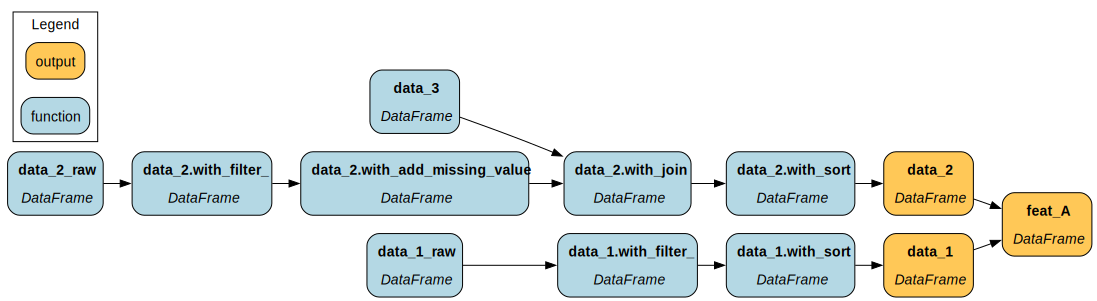

,col_1,col_2
3,0,d
1,2,b
0,3,a


,col_1,col_2
col_2,,
150,a,10
155,b,23
145,c,32
200,d,50
5000,e,0


,col_0,col_1,col_3,col_2
0,d,0,200,50
1,b,2,155,23
2,a,3,150,10


In [5]:
%%cell_to_module -m mutate --display --write_to_file --execute node_to_execute

from typing import Any, List
import pandas as pd
from hamilton.function_modifiers import mutate, apply_to, source, value

def data_1()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [3, 2, pd.NA, 0], 'col_2': ['a', 'b', pd.NA, 'd']})
    return df

def data_2()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': ['a', 'b', pd.NA, 'd', 'e'], 'col_2': [150, 155, 145, 200, 5000]})
    return df

def data_3()->pd.DataFrame:
    df = pd.DataFrame.from_dict({'col_1': [150, 155, 145, 200, 5000], 'col_2': [10,23, 32, 50, 0]})
    return df

# data1 and data2
@mutate(
    data_1, data_2
    )
def filter_(some_data:pd.DataFrame)->pd.DataFrame:
    """Remove NAN values.
    
    Decorated with mutate this will be applied to both data_1 and data_2.
    """
    return some_data.dropna()

# data 2
# this is for value
@mutate(
    data_2, 
    missing_row=value(['c', 145])
    )
def add_missing_value(some_data:pd.DataFrame, missing_row:List[Any])->pd.DataFrame:
    """Add row to dataframe.
    
    The functions decorated with mutate can be viewed as steps in pipe_output in the order they
    are implemented. This means that data_2 had a row removed with NAN and here we add back a row
    by hand that replaces that row.
    """
    some_data.loc[-1] = missing_row
    return some_data

# data 2
# this is for source
@mutate(
    data_2, 
    other_data=source('data_3')
    )
def join(some_data:pd.DataFrame, other_data:pd.DataFrame)->pd.DataFrame:
    """Join two dataframes.
    
    We can use results from other nodes in the DAG by using the `source` functionality. Here we join
    data_2 table with another table - data_3 - that is the output of another node.
    """
    return some_data.set_index('col_2').join(other_data.set_index('col_1'))

# data1 and data2
@mutate(
    data_1, data_2
)
def sort(some_data:pd.DataFrame)->pd.DataFrame:
    """Sort dataframes by first column.
    
    This is the last step of our pipeline(s) and gets again applied to data_1 and data_2. We did some 
    light pre-processing on data_1 by removing NANs and sorting and more elaborate pre-processing on
    data_2 where we added values and joined another table.
    """
    columns = some_data.columns
    return some_data.sort_values(by=columns[0])

def feat_A(data_1:pd.DataFrame, data_2:pd.DataFrame)->pd.DataFrame:
    """Combining two raw dataframes to create a feature."""
    return (data_1.set_index('col_2').join(data_2.reset_index(names=['col_3']).set_index('col_1'))).reset_index(names=["col_0"])


# We can run such pipelines also remotely and can track them in the UI

In [ ]:
from hamilton import base
from hamilton_sdk import adapters
from hamilton.plugins.h_ray import RayGraphAdapter,RayTaskExecutor
import ray

import mutate

remote_executor = RayTaskExecutor(num_cpus=4)
shutdown = ray.shutdown

project_id = 3
username = "jf"

In [ ]:
tracker_ray = adapters.HamiltonTracker(
            project_id=project_id,
            username=username,
            dag_name="mutate ray graph adapter",
        )
ray.init()
rga = RayGraphAdapter(result_builder=base.DictResult(), shutdown_ray_on_completion=True)
dr = driver.Builder().with_modules(mutate).with_adapters(rga, tracker_ray).build()
result = dr.execute(final_vars=["data_1", "data_2", "feat_A"])
print(result)

In [ ]:
tracker_ray = adapters.HamiltonTracker(
            project_id=project_id,
            username=username,
            dag_name="mutate ray task executor",
        )

dr = (
        driver.Builder()
        .enable_dynamic_execution(allow_experimental_mode=True)
        .with_modules(mutate)
        .with_remote_executor(remote_executor)
        .with_adapters(tracker_ray)
        .build()
    )

print(dr.execute(final_vars=["data_1", "data_2", "feat_A"]))
if shutdown is not None:
    shutdown()


# pipe_output allows for targeting specific nodes


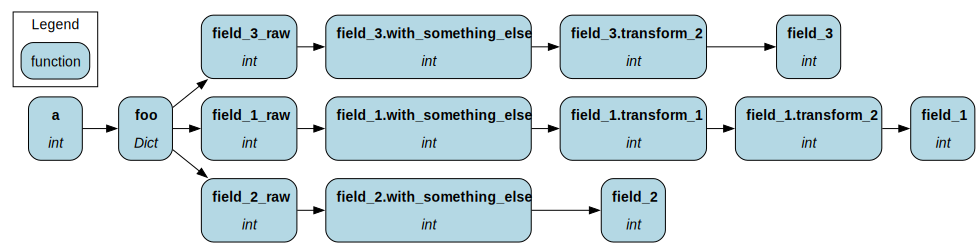

In [6]:
%%cell_to_module -m pipe_output_on_output --display --write_to_file
from typing import Dict
from hamilton.function_modifiers import extract_fields, pipe_input, pipe_output, step, hamilton_exclude

@hamilton_exclude
def pre_step(something:int)->int:
        return something + 10

@hamilton_exclude
def post_step(something:int)->int:
        return something + 100

@hamilton_exclude
def something_else(something:int)->int:
        return something + 1000

def a()->int:
        return 10

@pipe_output(
        step(something_else), # gets applied to all sink nodes
        step(pre_step).named(name="transform_1").on_output("field_1"), # only applied to field_1
        step(post_step).named(name="transform_2").on_output(["field_1", "field_3"]), # applied to field_1 and field_3
)
@extract_fields(
        {"field_1":int, "field_2":int, "field_3":int}
)
def foo(a:int)->Dict[str,int]:
    return {"field_1":1, "field_2":2, "field_3":3}

# Similarly mutate allows to specify which nodes it gets applied to


In [7]:
node_to_execute = ["data_1", "data_2", "feat_C", "feat_D"]

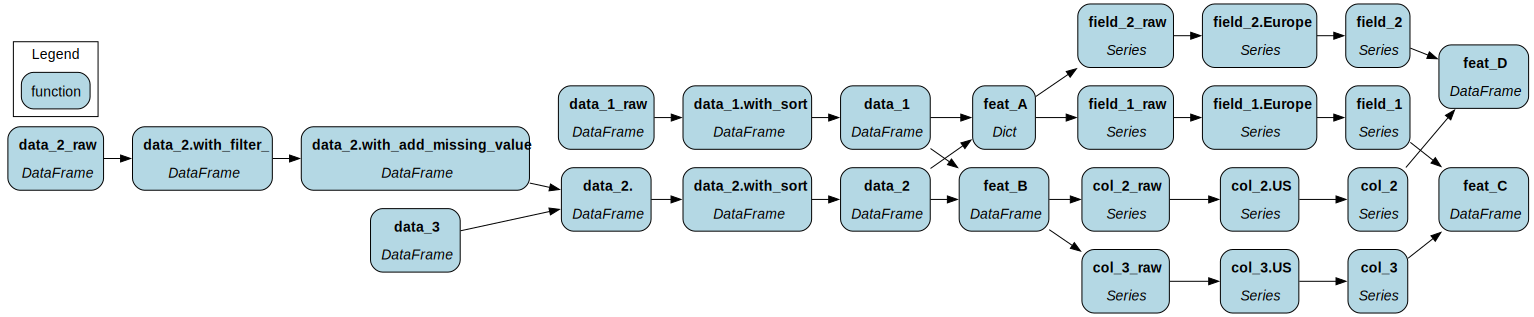

In [8]:
%%cell_to_module -m mutate_on_output --display --write_to_file

from typing import Any, Dict, List
import pandas as pd
from hamilton.function_modifiers import extract_fields, extract_columns, apply_to, mutate, value, source


def data_1() -> pd.DataFrame:
    df = pd.DataFrame.from_dict({"col_1": [3, 2, pd.NA, 0], "col_2": ["a", "b", pd.NA, "d"]})
    return df


def data_2() -> pd.DataFrame:
    df = pd.DataFrame.from_dict(
        {"col_1": ["a", "b", pd.NA, "d", "e"], "col_2": [150, 155, 145, 200, 5000]}
    )
    return df


def data_3() -> pd.DataFrame:
    df = pd.DataFrame.from_dict({"col_1": [150, 155, 145, 200, 5000], "col_2": [10, 23, 32, 50, 0]})
    return df


@extract_fields(
        {'field_1':pd.Series,
        'field_2':pd.Series})
def feat_A(data_1:pd.DataFrame, data_2:pd.DataFrame)->Dict[str, pd.Series]:
    df = (data_1.set_index('col_2').join(data_2.reset_index(names=['col_3']).set_index('col_1'))).reset_index(names=["col_0"])
    return {
        "field_1": df.iloc[:, 1],
        "field_2": df.iloc[:, 2]
    }


@extract_columns('col_2','col_3')
def feat_B(data_1:pd.DataFrame, data_2:pd.DataFrame)->pd.DataFrame:
    return (data_1.set_index('col_2').join(data_2.reset_index(names=['col_3']).set_index('col_1'))).reset_index(names=["col_0"])


def feat_C(field_1:pd.Series, col_3:pd.Series)->pd.DataFrame:
    return pd.concat([field_1, col_3], axis=1)

def feat_D(field_2:pd.Series, col_2:pd.Series)->pd.DataFrame:
    return pd.concat([field_2, col_2], axis=1)

# data1 and data2
@mutate(
        apply_to(data_1).when_in(a=[1,2,3]),
        apply_to(data_2).when_not_in(a=[1,2,3])
)
def filter_(some_data:pd.DataFrame)->pd.DataFrame:
    """Remove NAN values.
    
    Mutate accepts a `config.*` family conditional where we can choose when the transform will be applied
    onto the target function.
    """
    return some_data.dropna()

# data 2
# this is for value
@mutate(apply_to(data_2), missing_row=value(['c', 145]))
def add_missing_value(some_data:pd.DataFrame, missing_row:List[Any])->pd.DataFrame:
    """Add row to dataframe.
    
    The functions decorated with mutate can be viewed as steps in pipe_output in the order they
    are implemented. This means that data_2 had a row removed with NAN and here we add back a row
    by hand that replaces that row.
    """
    some_data.loc[-1] = missing_row
    return some_data

# data 2
# this is for source
@mutate(apply_to(data_2).named(name="",namespace="some_random_namespace"), other_data=source('data_3'))
def join(some_data:pd.DataFrame, other_data:pd.DataFrame)->pd.DataFrame:
    """Join two dataframes.
    
    We can use results from other nodes in the DAG by using the `source` functionality. Here we join
    data_2 table with another table - data_3 - that is the output of another node.

    In addition, mutate also support adding custom names to the nodes.
    """
    return some_data.set_index('col_2').join(other_data.set_index('col_1'))

# data1 and data2
@mutate(
    apply_to(data_1),
    apply_to(data_2)
)
def sort(some_data:pd.DataFrame)->pd.DataFrame:
    """Sort dataframes by first column.
    
    This is the last step of our pipeline(s) and gets again applied to data_1 and data_2. We did some 
    light pre-processing on data_1 by removing NANs and sorting and more elaborate pre-processing on
    data_2 where we added values and joined another table.
    """
    columns = some_data.columns
    return some_data.sort_values(by=columns[0])


# we want to apply some adjustment coefficient to all the columns of feat_B, but only to field_1 of feat_A
@mutate(
        apply_to(feat_A, factor=value(100)).on_output('field_1').named("Europe"),
        apply_to(feat_B, factor=value(10)).named("US")
)
def _adjustment_factor(some_data:pd.Series, factor:float)->pd.Series:
    """Adjust the value by some factor.
    
    You can imagine this step occurring later in time. We first constructed our DAG with features A and
    B only to realize that something is off. We are now experimenting post-hoc to improve and find the 
    best possible features.

    We first split the features by columns of interest and then adjust them by a regional factor to 
    combine them into improved features we can use further down the pipeline.
    """
    return some_data * factor


# Apply mutate twice by copying the function

In [9]:
node_to_execute = ["data_1"]

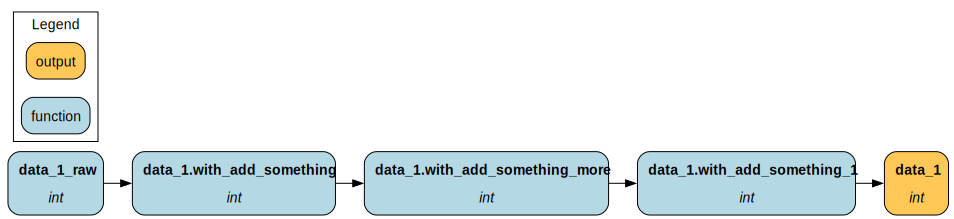

1210

In [10]:
%%cell_to_module -m mutate_twice_the_same --display --write_to_file --execute node_to_execute

from typing import Any, List
import pandas as pd
from hamilton.function_modifiers import mutate, apply_to, source, value


def data_1()->int:
    return 10


@mutate(data_1)
def add_something(user_input:int)->int:
    return user_input + 100

@mutate(data_1)
def add_something_more(user_input:int)->int:
    return user_input + 1000

@mutate(data_1)
def add_something(user_input:int)->int: # noqa
    return user_input + 100



